In [1]:
import os
import sys
import pprint
import csv
import statistics
import pandas as pd
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import radical.pilot as rp
import radical.utils     as ru
import radical.analytics as ra
import rp_analytics as rp_data
import parsl_analytics as parsl_data
from matplotlib import cm
blues = cm.get_cmap(plt.get_cmap('Blues'))
greens = cm.get_cmap(plt.get_cmap('Greens'))
reds = cm.get_cmap(plt.get_cmap('Reds'))
oranges = cm.get_cmap(plt.get_cmap('Oranges'))
purples = cm.get_cmap(plt.get_cmap('Purples'))
greys = cm.get_cmap(plt.get_cmap('Greys'))

# Font sizes
SIZE = 20
plt.rc('font'  , size      = SIZE  ) # controls default text sizes
plt.rc('axes'  , titlesize = SIZE  ) # fontsize of the axes title
plt.rc('axes'  , labelsize = SIZE  ) # fontsize of the x any y labels
plt.rc('xtick' , labelsize = SIZE  ) # fontsize of the tick labels
plt.rc('ytick' , labelsize = SIZE  ) # fontsize of the tick labels
plt.rc('legend', fontsize  = SIZE-2) # legend fontsize
plt.rc('figure', titlesize = SIZE  ) # size of the figure title

from IPython.core.display import display, HTML
# Expand the notebook to the width of the browser
display(HTML("<style>.container { width:100% !important; }</style>"))

# Matplotlib style
plt.style.use('seaborn-ticks')

# Use LaTeX and its body font for the diagrams' text.
#mpl.rcParams['text.usetex'] = True
#mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['font.serif']  = ['Nimbus Roman Becker No9L']
mpl.rcParams['font.family'] = 'DejaVu Sans'

In [2]:
!radical-stack
!which python


  python               : 3.7.0
  pythonpath           : 
  virtualenv           : /home/aymen/iwp

  radical.analytics    : 0.90.7
  radical.entk         : 1.0.2
  radical.pilot        : 1.3.0
  radical.saga         : 1.3.0
  radical.utils        : 1.3.1

/opt/anaconda3/bin/python


In [3]:
RP    = rp_data.get_session_tstamps()
PARSL = parsl_data.get_session_tstamps()

session loaded
session loaded
session loaded
session loaded
[322.8439998626709, 341.6819996833801, 320.6989998817444, 366.27500009536743]


8.350594497838266 21.150249779429956


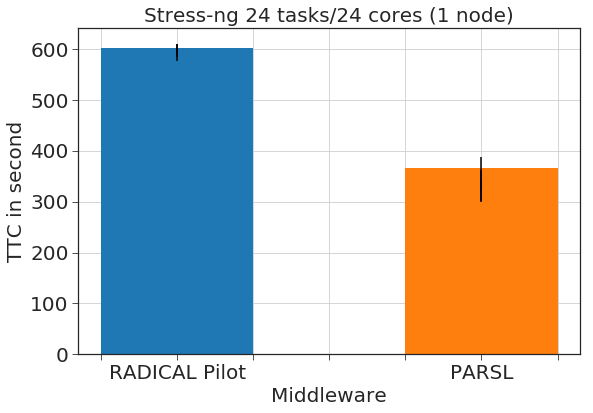

In [4]:
rp_std = statistics.stdev(RP)
parsl_std = statistics.stdev(PARSL)
print(rp_std, parsl_std)
# create figure and axis objects with subplots()
fig,ax=plt.subplots(figsize=(9,6))
RP_gr = statistics.mean(RP)
PARSL_gr = statistics.mean(PARSL)
ax.bar(1,RP,yerr=rp_std, width=0.5)
ax.set_xlabel("Middleware")
ax.set_ylabel("TTC in second")
ax.bar(2,PARSL, yerr=parsl_std, width=0.5)
ax.grid()
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[2] = 'RADICAL Pilot'
labels[6] = 'PARSL'
ax.title.set_text("Stress-ng 24 tasks/24 cores (1 node)")
ax.set_xticklabels(labels)
plt.show()

In [5]:
ss = {}
loc = [dI for dI in os.listdir('../RP/sessions/') if os.path.isdir(os.path.join('../RP/sessions/',dI))]
print (len(loc))
for session in range(len(loc)):
    sp = os.path.join('../RP/sessions/',loc[session])
    ss[session] = {'s': ra.Session(sp, 'radical.pilot')}
    ss[session].update({'p': ss[session]['s'].filter(etype='pilot'   , inplace=False),
                        'u': ss[session]['s'].filter(etype='unit'    , inplace=False)})
    
tableau20 = [(31 , 119, 180), (174, 199, 232), # blue        [ 0,1 ]
             (255, 127, 14 ), (255, 187, 120), # orange      [ 2,3 ]
             (44 , 160, 44 ), (152, 223, 138), # green       [ 4,5 ]
             (214, 39 , 40 ), (255, 152, 150), # red         [ 6,7 ]
             (148, 103, 189), (197, 176, 213), # purple      [ 8,9 ]
             (140, 86 , 75 ), (196, 156, 148), # brown       [10,11]
             (227, 119, 194), (247, 182, 210), # pink        [12,13]
             (188, 189, 34 ), (219, 219, 141), # yellow      [14,15]
             (23 , 190, 207), (158, 218, 229), # cyan        [16,17]
             (65 , 68 , 81 ), (96 , 99 , 106), # gray        [18,19]
             (127, 127, 127), (143, 135, 130), # gray        [20,21]
             (165, 172, 175), (199, 199, 199), # gray        [22,23]
             (207, 207, 207)]                  # gray        [24]

# Scale the RGB values to the [0, 1] range, which is the format
# matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (round(r/255.,1), round(g/255.,1), round(b/255.,1))

4
session loaded
session loaded
session loaded
session loaded
session loaded
session loaded
session loaded
session loaded
session loaded
session loaded
session loaded
session loaded


In [6]:
from radical.pilot import states as rps

for sid in range(len(loc)):
    u  = ss[sid]['u']

    ss[sid].update({
        'umgr_sched_queue'  : u.duration( event=[{ru.STATE: rps.NEW                        },
                                                 {ru.STATE: rps.UMGR_SCHEDULING            } ]), 
        'umgr_stage_input'  : u.duration( event=[{ru.STATE: rps.UMGR_STAGING_INPUT_PENDING },
                                                 {ru.STATE: rps.UMGR_STAGING_INPUT         } ]), 
        'agent_stage_input' : u.duration( event=[{ru.STATE: rps.AGENT_STAGING_INPUT_PENDING},
                                                 {ru.STATE: rps.AGENT_SCHEDULING_PENDING   } ]), 
        'agent_sched_queue' : u.duration( event=[{ru.STATE: rps.AGENT_SCHEDULING_PENDING   },
                                                 {ru.EVENT: 'schedule_ok'                  } ]), 
        'agent_exec_queue'  : u.duration( event=[{ru.EVENT: 'schedule_ok'                  },
                                                 {ru.STATE: rps.AGENT_EXECUTING            } ]),
        'agent_exec_prep'   : u.duration( event=[{ru.STATE: rps.AGENT_EXECUTING            },
                                                 {ru.EVENT: 'exec_start'                   } ]),
        'agent_exec_rp'     : u.duration( event=[{ru.EVENT: 'exec_start'                   },
                                                 {ru.EVENT: 'cu_start'                     } ]),
        'agent_exec_sh'     : u.duration( event=[{ru.EVENT: 'cu_start'                     },
                                                 {ru.EVENT: 'cu_exec_start'                } ]),
        'agent_exec_cmd'    : u.duration( event=[{ru.EVENT: 'cu_exec_start'                },
                                                 {ru.EVENT: 'cu_exec_stop'                 } ]),
        'agent_term_sh'     : u.duration( event=[{ru.EVENT: 'cu_exec_stop'                 },
                                                 {ru.EVENT: 'cu_stop'                      } ]),
        'agent_term_rp'     : u.duration( event=[{ru.EVENT: 'cu_stop'                      },
                                                 {ru.EVENT: 'exec_stop'                    } ]),
        'agent_unschedule'  : u.duration( event=[{ru.EVENT: 'exec_stop'                    },
                                                 {ru.EVENT: 'unschedule_stop'              } ]),
        'agent_stage_output': u.duration( event=[{ru.EVENT: 'unschedule_stop'              },
                                                 {ru.STATE: rps.UMGR_STAGING_OUTPUT        } ])
    })

In [7]:
ss

{0: {'agent_exec_cmd': 303.0,
  'agent_exec_prep': 2.619751214981079,
  'agent_exec_queue': 0.25472569465637207,
  'agent_exec_rp': 3.4516968727111816,
  'agent_exec_sh': 5.0,
  'agent_sched_queue': 0.13094782829284668,
  'agent_stage_input': 77.54514145851135,
  'agent_stage_output': 2.033050298690796,
  'agent_term_rp': 3.1795268058776855,
  'agent_term_sh': 3.0,
  'agent_unschedule': 0.6869757175445557,
  'p': <radical.analytics.session.Session at 0x7f084f597cf8>,
  's': <radical.analytics.session.Session at 0x7f084da2e780>,
  'u': <radical.analytics.session.Session at 0x7f084de789e8>,
  'umgr_sched_queue': 0.07364940643310547,
  'umgr_stage_input': 0.06025409698486328},
 1: {'agent_exec_cmd': 304.0,
  'agent_exec_prep': 3.7101950645446777,
  'agent_exec_queue': 0.3983125686645508,
  'agent_exec_rp': 4.374239921569824,
  'agent_exec_sh': 5.0,
  'agent_sched_queue': 0.19534778594970703,
  'agent_stage_input': 70.3770227432251,
  'agent_stage_output': 4.444326400756836,
  'agent_term_

In [8]:
for sid in range(len(loc)):
    print("""
%s:
\tumgr_sched_queue  : %s
\tumgr_stage_input  : %s
\tagent_stage_input : %s
\tagent_sched_queue : %s
\tagent_exec_queue  : %s
\tagent_exec_prep   : %s
\tagent_exec_rp     : %s
\tagent_exec_sh     : %s
\tagent_exec_cmd    : %s
\tagent_term_sh     : %s
\tagent_term_rp     : %s
\tagent_unschedule  : %s
\tagent_stage_output: %s
""" % (sid                         , 
       ss[sid]['umgr_sched_queue'] ,
       ss[sid]['umgr_stage_input'] ,
       ss[sid]['agent_stage_input'],
       ss[sid]['agent_sched_queue'],
       ss[sid]['agent_exec_queue'] , 
       ss[sid]['agent_exec_prep']  , 
       ss[sid]['agent_exec_rp']    , 
       ss[sid]['agent_exec_sh']    , 
       ss[sid]['agent_exec_cmd']   , 
       ss[sid]['agent_term_sh']    , 
       ss[sid]['agent_term_rp']    , 
       ss[sid]['agent_unschedule'] ,
       ss[sid]['agent_stage_output']))


0:
	umgr_sched_queue  : 0.07364940643310547
	umgr_stage_input  : 0.06025409698486328
	agent_stage_input : 77.54514145851135
	agent_sched_queue : 0.13094782829284668
	agent_exec_queue  : 0.25472569465637207
	agent_exec_prep   : 2.619751214981079
	agent_exec_rp     : 3.4516968727111816
	agent_exec_sh     : 5.0
	agent_exec_cmd    : 303.0
	agent_term_sh     : 3.0
	agent_term_rp     : 3.1795268058776855
	agent_unschedule  : 0.6869757175445557
	agent_stage_output: 2.033050298690796


1:
	umgr_sched_queue  : 0.05265402793884277
	umgr_stage_input  : 0.10545158386230469
	agent_stage_input : 70.3770227432251
	agent_sched_queue : 0.19534778594970703
	agent_exec_queue  : 0.3983125686645508
	agent_exec_prep   : 3.7101950645446777
	agent_exec_rp     : 4.374239921569824
	agent_exec_sh     : 5.0
	agent_exec_cmd    : 304.0
	agent_term_sh     : 3.0
	agent_term_rp     : 2.94706654548645
	agent_unschedule  : 0.8756473064422607
	agent_stage_output: 4.444326400756836


2:
	umgr_sched_queue  : 0.06881546974

In [9]:
for sid in range(len(loc)):
    u  = ss[sid]['u']
    p  = ss[sid]['p']

    ss[sid].update({
      'ttc'  : p.duration(event=[ {ru.EVENT: 'state'         , ru.STATE: rp.NEW                }, 
                                   {ru.EVENT: 'state'        , ru.STATE: rp.CANCELED           } ]),
      'ttq_p': p.duration(event=[ {ru.EVENT: 'state'         , ru.STATE: rp.PMGR_ACTIVE_PENDING}, 
                                   {ru.EVENT: 'state'        , ru.STATE: rp.PMGR_ACTIVE        } ]),
      'ttx_u': u.duration( event=[ {ru.EVENT: 'cu_exec_start', ru.STATE: None                  },      
                                   {ru.EVENT: 'cu_exec_stop' , ru.STATE: None                  } ]),
      'ttx_p': p.duration(event=[ {ru.EVENT: 'state'         , ru.STATE: rp.PMGR_ACTIVE        },
                                  [{ru.EVENT: 'state'        , ru.STATE: rp.DONE               },
                                   {ru.EVENT: 'state'        , ru.STATE: rp.FAILED             },
                                   {ru.EVENT: 'state'        , ru.STATE: rp.CANCELED           }]])})
    
    ss[sid].update({'ovh_rtc':(ss[sid]['ttx_p'])-ss[sid]['ttx_u']})

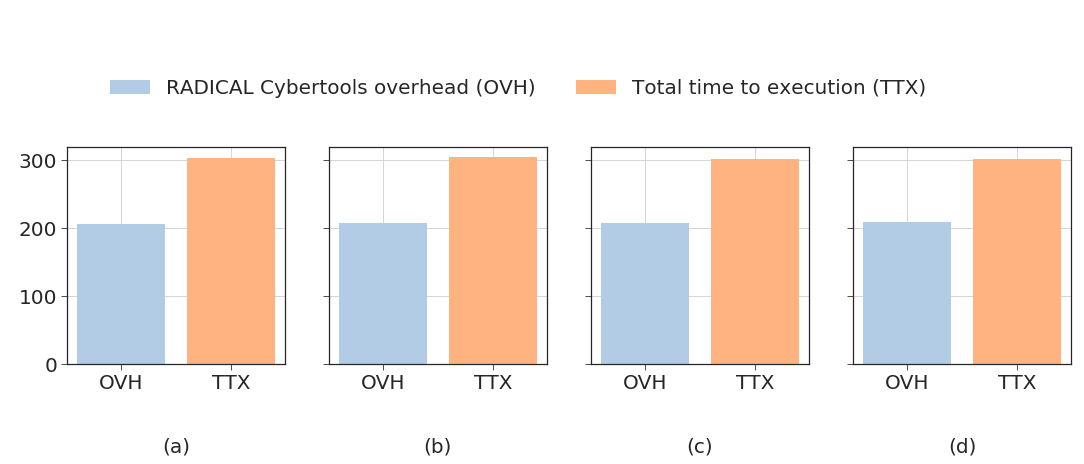

In [10]:
fwidth = 18
fhight = 4
fig, axarr = plt.subplots(1, len(loc), sharey=True, figsize=(fwidth, fhight))

i = 0
j = 'a'
for sid in range(len(loc)):
    
    ax = axarr[i]

    ax.bar(x = 'OVH', height = ss[sid]['ovh_rtc'], color = tableau20[1])
    ax.bar(x = 'TTX', height = ss[sid]['ttx_u']  , color = tableau20[3])
    ax.grid()
    ax.set_xlabel('(%s)' % j, labelpad=45)
    
    i = i+1
    j = chr(ord(j) + 1)


fig.legend(['RADICAL Cybertools overhead (OVH)', 'Total time to execution (TTX)'], loc='upper center', 
           bbox_to_anchor=(0.4, 1.4), fontsize=20, ncol=2)

## Breaking Down the sessions based on their events

Text(0.5, -0.8, 'Metric')

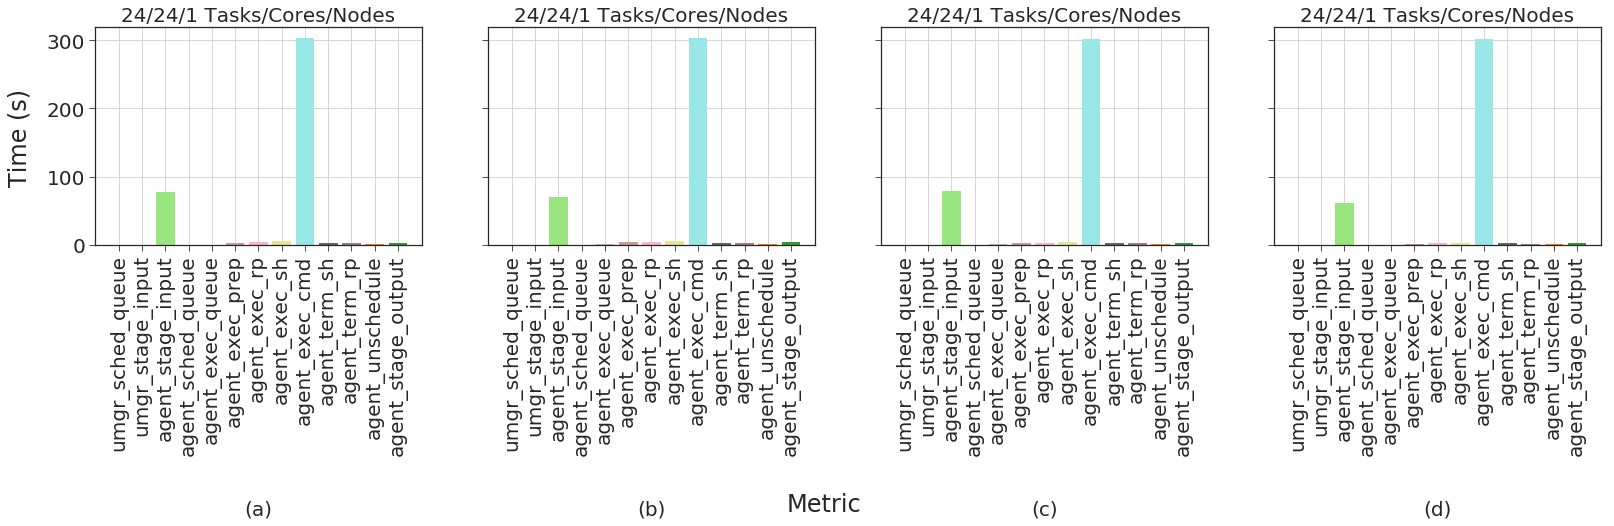

In [11]:
plt.rc('text', usetex=False)

fwidth = 27
fhight = 4
fig, axarr = plt.subplots(1,  len(loc), sharey=True, figsize=(fwidth, fhight))

i = 0
j = 'a'


for sid in range(len(loc)):
    
    ax = axarr[i]
    ax.title.set_text('%s/%s/%s Tasks/Cores/Nodes' % (24,24, int(1)))

    ax.bar(x = 'umgr_sched_queue', height = ss[sid]['umgr_sched_queue'], color = tableau20[1])
    ax.bar(x = 'umgr_stage_input', height = ss[sid]['umgr_stage_input'], color = tableau20[3])
    ax.bar(x = 'agent_stage_input', height = ss[sid]['agent_stage_input'], color = tableau20[5])
    ax.bar(x = 'agent_sched_queue', height = ss[sid]['agent_sched_queue'], color = tableau20[7])
    ax.bar(x = 'agent_exec_queue', height = ss[sid]['agent_exec_queue'], color = tableau20[9])
    ax.bar(x = 'agent_exec_prep', height = ss[sid]['agent_exec_prep'], color = tableau20[11])
    ax.bar(x = 'agent_exec_rp', height = ss[sid]['agent_exec_rp'], color = tableau20[13])
    ax.bar(x = 'agent_exec_sh', height = ss[sid]['agent_exec_sh'], color = tableau20[15])
    ax.bar(x = 'agent_exec_cmd', height = ss[sid]['agent_exec_cmd'], color = tableau20[17])
    ax.bar(x = 'agent_term_sh', height = ss[sid]['agent_term_sh'], color = tableau20[19])
    ax.bar(x = 'agent_term_rp', height = ss[sid]['agent_term_rp'], color = tableau20[21])
    ax.bar(x = 'agent_unschedule', height = ss[sid]['agent_unschedule'], color = tableau20[2])
    ax.bar(x = 'agent_stage_output', height = ss[sid]['agent_stage_output'], color = tableau20[4])
    ax.grid()
    ax.set_xlabel('(%s)' % j, labelpad=45)
    ax.tick_params(axis='x', labelrotation=90)
    
    i = i+1
    j = chr(ord(j) + 1)

fig.text(0.08,  0.5 , 'Time (s)', va='center', rotation='vertical', fontsize=24)
fig.text(0.5 , -0.8 , 'Metric'  , ha='center', fontsize=24)

## Breaking down the units of a single session based on their time stamps

session loaded
#entities: 24


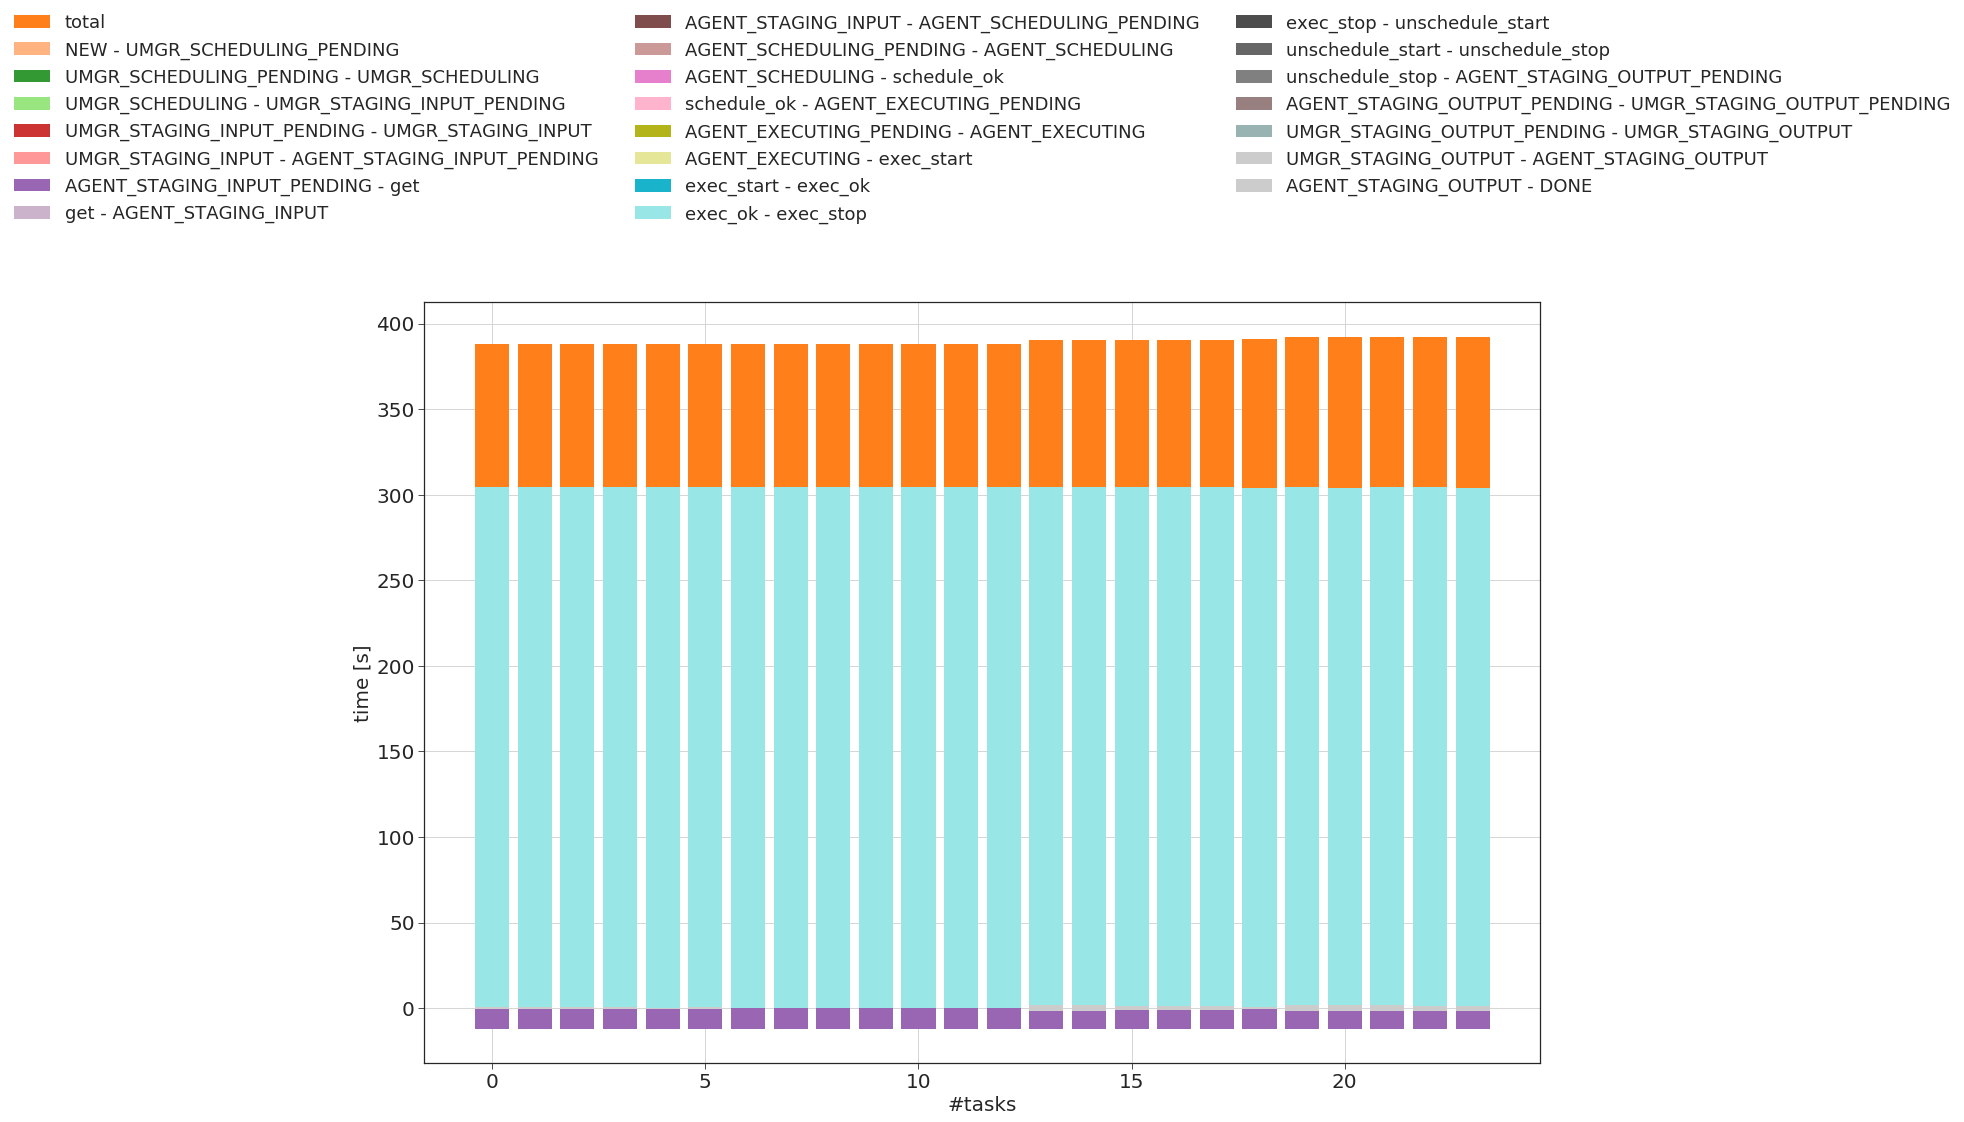

In [12]:
event_list   = \
    [
     {ru.STATE: 'NEW'                          , ru.EVENT: 'state'           },
     {ru.STATE: 'UMGR_SCHEDULING_PENDING'      , ru.EVENT: 'state'           },
     {ru.STATE: 'UMGR_SCHEDULING'              , ru.EVENT: 'state'           },
     {ru.STATE: 'UMGR_STAGING_INPUT_PENDING'   , ru.EVENT: 'state'           },
     {ru.STATE: 'UMGR_STAGING_INPUT'           , ru.EVENT: 'state'           },
     {ru.STATE: 'AGENT_STAGING_INPUT_PENDING'  , ru.EVENT: 'state'           },
     {ru.STATE: None                           , ru.EVENT: 'get'             },
     {ru.STATE: 'AGENT_STAGING_INPUT'          , ru.EVENT: 'state'           },
     {ru.STATE: 'AGENT_SCHEDULING_PENDING'     , ru.EVENT: 'state'           },
     {ru.STATE: 'AGENT_SCHEDULING'             , ru.EVENT: 'state'           },
     {ru.STATE: None                           , ru.EVENT: 'schedule_ok'     },
     {ru.STATE: 'AGENT_EXECUTING_PENDING'      , ru.EVENT: 'state'           },
     {ru.STATE: 'AGENT_EXECUTING'              , ru.EVENT: 'state'           },
     {ru.STATE: None                           , ru.EVENT: 'exec_start'      },
     {ru.STATE: None                           , ru.EVENT: 'exec_ok'         },
     {ru.STATE: None                           , ru.EVENT: 'exec_stop'       },
     {ru.STATE: None                           , ru.EVENT: 'unschedule_start'},
     {ru.STATE: None                           , ru.EVENT: 'unschedule_stop' },
     {ru.STATE: 'AGENT_STAGING_OUTPUT_PENDING' , ru.EVENT: 'state'           },
     {ru.STATE: 'UMGR_STAGING_OUTPUT_PENDING'  , ru.EVENT: 'state'           },
     {ru.STATE: 'UMGR_STAGING_OUTPUT'          , ru.EVENT: 'state'           },
     {ru.STATE: 'AGENT_STAGING_OUTPUT'         , ru.EVENT: 'state'           },
     {ru.STATE: 'DONE'                         , ru.EVENT: 'state'           },
    ]
    
def ppheader(message):
    separator = '\n' + 78 * '-' + '\n'
    print(separator + message + separator)
    
loc = [dI for dI in os.listdir('../RP/sessions/') if os.path.isdir(os.path.join('../RP/sessions/',dI))]

src = os.path.dirname(loc[1])
sid = os.path.basename(loc[1])
session = ra.Session(sid=sid, stype='radical.pilot', src=os.path.join('../RP/sessions/',loc[1]))
session.filter(etype='unit', inplace=True)

print('#entities: %d' % len(session.get()))

data = dict()
for thing in session.get():

    tstamps = list()

    for event in event_list:
        times = thing.timestamps(event=event)
        if times: tstamps.append(times[0])
        else    : tstamps.append(np.nan)

    data[thing.uid] = tstamps

# We sort the entities by the timestamp of the first event
# We also derive the durations, first the individual contributions, then the
# overall duration.
# timestamp in the list
sorted_things = sorted(list(data.items()), key=lambda e: e[1][0])
sorted_data   = list()
index         = 0
for uid,tstamps in sorted_things:

    durations = list()
    durations.append(tstamps[-1] - tstamps[0])  # global duration
    for i in range(len(tstamps) - 1):
        durations.append(tstamps[i + 1] - tstamps[i])

    # create plottable data
    sorted_data.append([index] + durations)
    index += 1

# create a numpyarray for plotting
np_data = np.array(sorted_data)
# print np_data

plt.figure(figsize=(20,14))
plt.ylabel('time [s]')
plt.xlabel('#tasks')
for e_idx in range(len(event_list)):
    if e_idx == 0:
        label = 'total'
    else:
        label = '%s - %s' % (ru.event_to_label(event_list[e_idx - 1]),
                             ru.event_to_label(event_list[e_idx]))
    plt.bar(np_data[:,0], np_data[:,(1 + e_idx)], label=label, color = tableau20[e_idx+2])
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4),ncol=3, fancybox=True)

In [13]:
PARSL = parsl_data.get_workers_tstamps()
PARSL

[300.67899990081787, 300.5989999771118, 300.6809997558594, 300.73299980163574, 300.7810001373291, 300.62099981307983, 301.2090001106262, 301.40000009536743, 301.1630001068115, 300.5989999771118, 301.38899993896484, 300.70199966430664, 300.753999710083, 300.97499990463257, 300.7530002593994, 300.8360004425049, 301.21399974823, 300.7420001029968, 300.6899995803833, 300.6380000114441, 300.95600032806396, 301.35599994659424, 301.0160002708435, 301.21900033950806, 301.01500034332275, 301.11299991607666, 301.26700019836426, 301.5050001144409, 301.375, 301.05200004577637, 301.0130000114441, 300.9249997138977, 300.98900032043457, 300.8829998970032, 301.0880002975464, 301.48400020599365, 301.6760001182556, 301.2999997138977, 301.61100006103516, 301.0959997177124, 301.0609998703003, 301.00600004196167, 301.3190002441406, 300.9210000038147, 300.9229998588562, 300.8880000114441, 301.3730001449585, 301.10200023651123, 301.4900002479553, 301.01900005340576, 300.8090000152588, 301.09999990463257, 300

{'dur': None,
 'sid': <_io.BufferedReader name=b'/home/aymen/SummerRadical/Parsl-RP/comet-test/Parsl/parsl_sessions/session0002/b7a03f62d982/worker_8.log'>}

In [14]:
PARSL = parsl_data.get_manager_tstamps()

[298.17399978637695, 298.95899963378906, 308.29899978637695, 298.2350001335144]
